In [1]:
%matplotlib inline
import empymod
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
from matplotlib.ticker import LogLocator, NullFormatter
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline
plt.style.use('ggplot')
import pandas as pd

from scipy import interpolate
from tqdm import trange


In [2]:
def _readfloat(line,File):
    a_list = File[line].split()
    map_object = map(float, a_list)
    return list(map_object)

def _readwaveform(line,File):
    a_list = File[line].split()
    map_object = list(map(float, a_list))
    nPoints = int(map_object[0])
    times = []
    norm_amp = []
    for i in range(1,nPoints*4 + 1,4):
        times.append(map_object[i])
        times.append(map_object[i+1])
        norm_amp.append(map_object[i+2])
        norm_amp.append(map_object[i+3])   
    return times,norm_amp


Function to get a model

In [3]:
with open('LowMoment.tem', 'r') as f:
    File = f.readlines()

HM = {}
LM = {}

LM['coordinates_receiver'] = _readfloat(2,File)
LM['nWire'],LM['LoopArea'] = _readfloat(3,File)
LM['WirePosition'] = []
for i in range(int(LM['nWire'])):
    LM['WirePosition'].append(_readfloat(4+i,File))
idx = 4 + int(LM['nWire'])+ 2
LM['waveform_times'],LM['waveform_current'] = _readwaveform(idx,File)
idx += 1
LM['NFiltersBeforeFG'], LM['BoolFG'], LM['DampingFactor'] = _readfloat(idx,File)
idx += 1
LM['FiltersBeforeFG'] = []
for i in range(int(LM['NFiltersBeforeFG'])):
    NCutOff, FOrder, FCutOff = _readfloat(idx,File)
    LM['FiltersBeforeFG'].append([NCutOff, FOrder, FCutOff])
    idx += 2
LM['FGTime'] = _readfloat(idx,File)
idx += 1
NCutOff, FOrder, FCutOff = _readfloat(idx,File)
LM['FiltersAfterFG']=[NCutOff, FOrder, FCutOff]
idx += 2
LM['gates'] = []
for i in range(len(File)-idx):
    LM['gates'].append(_readfloat(idx+i,File)[0])
    
with open('HighMoment.tem', 'r') as f:
    File = f.readlines()
    
HM['coordinates_receiver'] = _readfloat(2,File)
HM['nWire'],HM['LoopArea'] = _readfloat(3,File)
HM['WirePosition'] = []
for i in range(int(HM['nWire'])):
    HM['WirePosition'].append(_readfloat(4+i,File))
idx = 4 + int(HM['nWire'])+ 2
HM['waveform_times'],HM['waveform_current'] = _readwaveform(idx,File)
idx += 1
HM['NFiltersBeforeFG'], HM['BoolFG'], HM['DampingFactor'] = _readfloat(idx,File)
idx += 1
HM['FiltersBeforeFG'] = []
for i in range(int(HM['NFiltersBeforeFG'])):
    NCutOff, FOrder, FCutOff = _readfloat(idx,File)
    HM['FiltersBeforeFG'].append([NCutOff, FOrder, FCutOff])
    idx += 2
HM['FGTime'] = _readfloat(idx,File)
idx += 1
NCutOff, FOrder, FCutOff = _readfloat(idx,File)
HM['FiltersAfterFG']=[NCutOff, FOrder, FCutOff]
idx += 2
HM['gates'] = []
for i in range(len(File)-idx):
    HM['gates'].append(_readfloat(idx+i,File)[0])
    

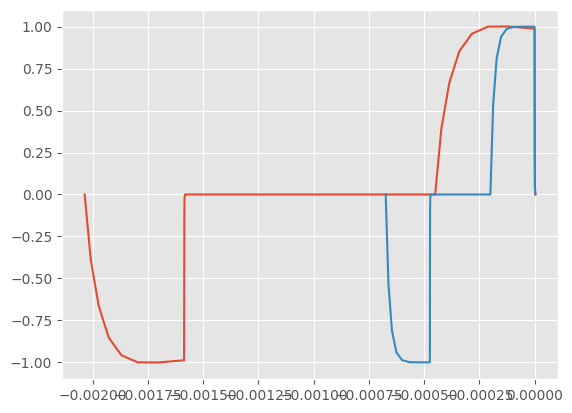

In [4]:
plt.plot(HM['waveform_times'],HM['waveform_current'])
plt.plot(LM['waveform_times'],LM['waveform_current'])


In [5]:
nPoints = 45


In [6]:
def get_model():
    #load the model
    global model_ref
    global forward
    model_ref = pd.read_table('D:/Alexis/01_Projets/01_Phenix/Admin/Redaction_Data_Descr/Data/final/Smooth_Model.inv',header=6,delim_whitespace=True)
    forward = pd.read_table('D:/Alexis/01_Projets/01_Phenix/Admin/Redaction_Data_Descr/Data/final/Forward_Data_Smooth.dat',header=8,delim_whitespace=True)
    forward.replace(9999, np.nan, inplace=True)
    
    return

def get_gates():
    gates_syn = pd.read_table('../Gates_from_Syn.txt')

    

    lm_off_time = gates_syn.Mid.to_numpy()[:4]
    hm_off_time = gates_syn.Mid.to_numpy()[3:]
   
    plt.plot(gates_syn.Mid.to_numpy(), 'o-', color = 'r')
    plt.plot(lm_off_time, 'o-', color = 'b')

    plt.legend(['Center Times'])
    plt.yscale('log')
    return [lm_off_time,hm_off_time]

def get_gates_new():
    
    lm_off_time = np.array(LM['gates'])
    hm_off_time = np.array(HM['gates'])
    
    return [lm_off_time,hm_off_time]

def get_gates_gex():
    gates_syn = pd.read_table('../Gates_gex.txt')

    

    lm_off_time = gates_syn.Mid.to_numpy()[:4]
    hm_off_time = gates_syn.Mid.to_numpy()[3:-1]
   
    plt.plot(gates_syn.Mid.to_numpy(), 'o-', color = 'r')
    plt.plot(lm_off_time, 'o-', color = 'b')

    plt.legend(['Center Times'])
    plt.yscale('log')
    return [lm_off_time,hm_off_time]

def get_aarhusForward(modelnumer, gates, plot = True):
    if  "model_ref" not in globals():
        print('importing model')
        get_model()
    
    thicknesses = model_ref.iloc[modelnumer,36:65].to_numpy()
    res_fromModel = model_ref.iloc[modelnumer,6:36].to_numpy()
    reccord = model_ref.iloc[modelnumer,0]
    foward_of_int = forward[forward['/RECORD'] == reccord]
    foward_of_int
    if len(foward_of_int) == 2:
        if plot :
            print('Two moments found')
        flag = 2
        # Low moment
        lm_aarhus_res = foward_of_int.iloc[1].to_numpy()[7:11]
        if plot:
            plot_moment(lm_aarhus_res, gates[0], label = 'LM')
        # High moment
        hm_aarhus_res = foward_of_int.iloc[0].to_numpy()[10:]
        if plot:
            plot_moment(hm_aarhus_res, gates[1], label = 'HM')

    
    if len(foward_of_int) == 1:
        if plot:
            print('One moment found')
        # Low moment
        lm_aarhus_res = foward_of_int.iloc[0].to_numpy()[7:11]
        
        # High moment
        hm_aarhus_res = foward_of_int.iloc[0].to_numpy()[10:30]

            
            
        
    return [[thicknesses,res_fromModel], lm_aarhus_res, hm_aarhus_res]

def plot_moment(forw, gate,label='Moment'):
    
    # AarhusInv
    plt.plot(gate, forw, 'x',label=label)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Time(s)")
    plt.ylabel(r"$\mathrm{d}\mathrm{B}_\mathrm{z}\,/\,\mathrm{d}t$")
    plt.grid(which='both', c='w')
    plt.legend(title='Data', loc=1)
    return

def plot_model(model):
    
    thick = model[0]
    
    res_plt  = model[1]
    res_plt = np.vstack([res_plt,res_plt])
    res_plt = res_plt.T.flatten()[:-1]

    thick_plt  = np.cumsum(model[0])
    thick_plt = np.vstack([thick_plt,thick_plt+ 0.000001])
    thick_plt = np.insert(thick_plt.T,0,0)
    thick_plt[-1] = thick_plt[-1] + 50
    

    plt.plot(res_plt, thick_plt, linewidth =2, color = 'k')
    
    plt.xscale('log')
    plt.legend(['Resisitivity Model'])
    plt.xlabel("Resisitivity [ohmm]")
    plt.ylabel('Depth [m]')
    plt.grid(which='both', c='w')
    plt.ylim(125,0)
    plt.xlim(10,500)

    return

def get_waveform_new(plot=True):
    #Read HM Waveform
    hm_waveform_times = np.array(HM['waveform_times'])
    hm_waveform_current = np.array(HM['waveform_current'])

    lm_waveform_times = np.array(LM['waveform_times'])
    lm_waveform_current = np.array(LM['waveform_current'])
    if plot:
        plt.title('Waveforms')
        plt.plot(np.r_[-3, lm_waveform_times*1e3, 1], np.r_[0, lm_waveform_current, 0],
                 label='Low moment')
        plt.plot(np.r_[-3, hm_waveform_times*1e3, 1], np.r_[0, hm_waveform_current, 0],
                 '-.', label='High moment')
        plt.xlabel('Time (ms)')
        plt.xlim([-2.5, 0.5])
        plt.legend()
    
    return [[lm_waveform_times,lm_waveform_current],[hm_waveform_times,hm_waveform_current]]

def get_waveform(plot=True):
    #Read HM Waveform
    WaveForm_HM = pd.read_table('../WaveForm_HM.txt',delim_whitespace=True,float_precision='high')
    WaveForm_LM = pd.read_table('../WaveForm_LM.txt',delim_whitespace=True,float_precision='high')

    hm_waveform_times = WaveForm_HM.Time.to_numpy()
    hm_waveform_current = WaveForm_HM.Amp.to_numpy()

    lm_waveform_times = WaveForm_LM.Time.to_numpy()
    lm_waveform_current = WaveForm_LM.Amp.to_numpy()
    if plot:
        plt.title('Waveforms')
        plt.plot(np.r_[-3, lm_waveform_times*1e3, 1], np.r_[0, lm_waveform_current, 0],
                 label='Low moment')
        plt.plot(np.r_[-3, hm_waveform_times*1e3, 1], np.r_[0, hm_waveform_current, 0],
                 '-.', label='High moment')
        plt.xlabel('Time (ms)')
        plt.xlim([-2.5, 0.5])
        plt.legend()
    
    return [[lm_waveform_times,lm_waveform_current],[hm_waveform_times,hm_waveform_current]]


def apply_waveform(times, resp, times_wanted, wave_time, wave_amp, nquad=3):
    """Apply a source waveform to the signal.

    Parameters
    ----------
    times : ndarray
        Times of computed input response; should start before and end after
        `times_wanted`.

    resp : ndarray
        EM-response corresponding to `times`.

    times_wanted : ndarray
        Wanted times.

    wave_time : ndarray
        Time steps of the wave.

    wave_amp : ndarray
        Amplitudes of the wave corresponding to `wave_time`, usually
        in the range of [0, 1].

    nquad : int
        Number of Gauss-Legendre points for the integration. Default is 3.

    Returns
    -------
    resp_wanted : ndarray
        EM field for `times_wanted`.

    """

    # Interpolate on log.
    PP = iuSpline(np.log10(times), resp)

    # Wave time steps.
    dt = np.diff(wave_time)
    dI = np.diff(wave_amp)
    dIdt = dI/dt

    # Gauss-Legendre Quadrature; 3 is generally good enough.
    # (Roots/weights could be cached.)
    g_x, g_w = roots_legendre(nquad)

    # Pre-allocate output.
    resp_wanted = np.zeros_like(times_wanted)

    # Loop over wave segments.
    for i, cdIdt in enumerate(dIdt):

        # We only have to consider segments with a change of current.
        if cdIdt == 0.0:
            continue

        # If wanted time is before a wave element, ignore it.
        ind_a = wave_time[i] < times_wanted
        if ind_a.sum() == 0:
            continue

        # If wanted time is within a wave element, we cut the element.
        ind_b = wave_time[i+1] > times_wanted[ind_a]

        # Start and end for this wave-segment for all times.
        ta = times_wanted[ind_a]-wave_time[i]
        tb = times_wanted[ind_a]-wave_time[i+1]
        tb[ind_b] = 0.0  # Cut elements

        # Gauss-Legendre for this wave segment. See
        # https://en.wikipedia.org/wiki/Gaussian_quadrature#Change_of_interval
        # for the change of interval, which makes this a bit more complex.
        logt = np.log10(np.outer((tb-ta)/2, g_x)+(ta+tb)[:, None]/2)
        fact = (tb-ta)/2*cdIdt
        resp_wanted[ind_a] += fact*np.sum(np.array(PP(logt)*g_w), axis=1)

    return resp_wanted

def get_time(time, r_time):
    """Additional time for ramp.

    Because of the arbitrary waveform, we need to compute some times before and
    after the actually wanted times for interpolation of the waveform.

    Some implementation details: The actual times here don't really matter. We
    create a vector of time.size+2, so it is similar to the input times and
    accounts that it will require a bit earlier and a bit later times. Really
    important are only the minimum and maximum times. The Fourier DLF, with
    `pts_per_dec=-1`, computes times from minimum to at least the maximum,
    where the actual spacing is defined by the filter spacing. It subsequently
    interpolates to the wanted times. Afterwards, we interpolate those again to
    compute the actual waveform response.

    Note: We could first call `waveform`, and get the actually required times
          from there. This would make this function obsolete. It would also
          avoid the double interpolation, first in `empymod.model.time` for the
          Fourier DLF with `pts_per_dec=-1`, and second in `waveform`. Doable.
          Probably not or marginally faster. And the code would become much
          less readable.

    Parameters
    ----------
    time : ndarray
        Desired times

    r_time : ndarray
        Waveform times

    Returns
    -------
    time_req : ndarray
        Required times
    """
    tmin = np.log10(max(time.min()-r_time.max(), 1e-10))
    #tmin = np.log10(time.min()-r_time.max())

    tmax = np.log10(time.max()-r_time.min())
    return np.logspace(tmin, tmax, time.size+2)

def tTEM(moment, model, waveform, gates, gates_tosim = True):
    """Custom wrapper of empymod.model.bipole.

    Here, we compute WalkTEM data using the ``empymod.model.bipole`` routine as
    an example. We could achieve the same using ``empymod.model.dipole`` or
    ``empymod.model.loop``.

    We model the big source square loop by computing only half of one side of
    the electric square loop and approximating the finite length dipole with 3
    point dipole sources. The result is then multiplied by 8, to account for
    all eight half-sides of the square loop.

    The implementation here assumes a central loop configuration, where the
    receiver (1 m2 area) is at the origin, and the source is a 40x40 m electric
    loop, centered around the origin.

    Note: This approximation of only using half of one of the four sides
          obviously only works for central, horizontal square loops. If your
          loop is arbitrary rotated, then you have to model all four sides of
          the loop and sum it up.


    Parameters
    ----------
    moment : str {'lm', 'hm'}
        Moment. If 'lm', above defined ``lm_off_time``, ``lm_waveform_times``,
        and ``lm_waveform_current`` are used. Else, the corresponding
        ``hm_``-parameters.

    depth : ndarray
        Depths of the resistivity model (see ``empymod.model.bipole`` for more
        info.)

    res : ndarray
        Resistivities of the resistivity model (see ``empymod.model.bipole``
        for more info.)

    Returns
    -------
    WalkTEM : EMArray
        WalkTEM response (dB/dt).

    """

    # Get the measurement time and the waveform corresponding to the provided
    # moment.
    depth, res = model
    depth = np.cumsum(depth)
    if moment == 'lm':
        off_time = gates[0]
        waveform_times = waveform[0][0]
        waveform_current = waveform[0][1]
        Amp = 1

    elif moment == 'hm':
        off_time = gates[1]
        waveform_times = waveform[1][0]
        waveform_current = waveform[1][1]
        Amp = 1
    else:
        raise ValueError("Moment must be either 'lm' or 'hm'!")

    # === GET REQUIRED TIMES ===
    time = get_time(off_time, waveform_times)

    # === GET REQUIRED FREQUENCIES ===
    time, freq, ft, ftarg = empymod.utils.check_time(
        time=time,          # Required times
        signal=1,           # Switch-on response
        ft='dlf',           # Use DLF
        ftarg={'dlf': 'key_81_CosSin_2009'},  # Short, fast filter; if you
        verb=2,                 # need higher accuracy choose a longer filter.
    )
    
    def Filter(f,cutoff,damping=0.99):                     # Define the Filter function that corresponds to the low pass RC filter.
        omega = 2*np.pi*f
        cnst = 1./(cutoff * 2.* np.pi)

        vout=( 1./(1j*omega*cnst+1.)) * damping
        return(vout)

    # === COMPUTE FREQUENCY-DOMAIN RESPONSE ===
    # We only define a few parameters here. You could extend this for any
    # parameter possible to provide to empymod.model.bipole.
    EM = empymod.model.bipole(
        src=[-2, 2,   1, 1, 0, 0],
        #src=[0, 9.36,  0, 0, 0], # El. bipole source; half of one side.
        rec=[-9.36, 0, 0.07, 0, 90],         # Receiver at the origin, vertical.
        depth=np.r_[0.5, depth+0.5],        # Depth-model, adding air-interface.
        res=np.r_[2e14, res],         # Provided resistivity model, adding air.
        # aniso=aniso,                # Here you could implement anisotropy...
        #                             # ...or any parameter accepted by bipole.
        freqtime=freq,                # Required frequencies.
        mrec=True,                    # It is an el. source, but a magn. rec.
        strength=1,                   # To account for 4 sides of square loop.
        srcpts=2,                     # Approx. the finite dip. with 3 points.
        #htarg={'dlf': 'key_101_2009'},
        verb=4,# Short filter, so fast.,
        ab=42
    )

    EM =+ empymod.model.bipole(
        src=[-2, 2,   -1, -1, 0, 0],
        #src=[0, 9.36,  0, 0, 0], # El. bipole source; half of one side.
        rec=[-9.36, 0, 0.07, 0, 90],         # Receiver at the origin, vertical.
        depth=np.r_[0.5, depth+0.5],        # Depth-model, adding air-interface.
        res=np.r_[2e14, res],         # Provided resistivity model, adding air.
        # aniso=aniso,                # Here you could implement anisotropy...
        #                             # ...or any parameter accepted by bipole.
        freqtime=freq,                # Required frequencies.
        mrec=True,                    # It is an el. source, but a magn. rec.
        strength=1,                   # To account for 4 sides of square loop.
        srcpts=2,                     # Approx. the finite dip. with 3 points.
        #htarg={'dlf': 'key_101_2009'},
        verb=4# Short filter, so fast.
    )

    EM =+ empymod.model.bipole(
        src=[-2, -2,   -1, 1, 0, 0],
        #src=[0, 9.36,  0, 0, 0], # El. bipole source; half of one side.
        rec=[-9.36, 0, 0.07, 0, 90],         # Receiver at the origin, vertical.
        depth=np.r_[0.5, depth+0.5],        # Depth-model, adding air-interface.
        res=np.r_[2e14, res],         # Provided resistivity model, adding air.
        # aniso=aniso,                # Here you could implement anisotropy...
        #                             # ...or any parameter accepted by bipole.
        freqtime=freq,                # Required frequencies.
        mrec=True,                    # It is an el. source, but a magn. rec.
        strength=1,                   # To account for 4 sides of square loop.
        srcpts=2,                     # Approx. the finite dip. with 3 points.
        #htarg={'dlf': 'key_101_2009'},
        verb=4# Short filter, so fast.
    )

    EM =+ empymod.model.bipole(
        src=[2, 2,   -1, 1, 0, 0],
        #src=[0, 9.36,  0, 0, 0], # El. bipole source; half of one side.
        rec=[-9.36, 0, 0.07, 0, 90],         # Receiver at the origin, vertical.
        depth=np.r_[0.5, depth+0.5],        # Depth-model, adding air-interface.
        res=np.r_[2e14, res],         # Provided resistivity model, adding air.
        # aniso=aniso,                # Here you could implement anisotropy...
        #                             # ...or any parameter accepted by bipole.
        freqtime=freq,                # Required frequencies.
        mrec=True,                    # It is an el. source, but a magn. rec.
        strength=1,                   # To account for 4 sides of square loop.
        srcpts=2,                     # Approx. the finite dip. with 3 points.
        #htarg={'dlf': 'key_101_2009'},
        verb=0# Short filter, so fast.
    )

        
    # Multiply the frequecny-domain result with
    # \mu for H->B, and i\omega for B->dB/dt.

    EM *= 2j*np.pi*freq*4e-7*np.pi

    # === Butterworth-type filter (implemented from simpegEM1D.Waveforms.py)===
    # Note: Here we just apply one filter. But it seems that WalkTEM can apply
    #       two filters, one before and one after the so-called front gate
    #       (which might be related to ``delay_rst``, I am not sure about that
    #       part.)
    cutofffreq = 420e+3               # As stated in the WalkTEM manual
    h = Filter(freq,cutofffreq,damping=0.84)  # First order type
    EM *= h

    cutofffreq = 6.79e+5               # As stated in the WalkTEM manual
    h = (1+1j*freq/cutofffreq)**-1   # First order type
    EM *= h

    # === CONVERT TO TIME DOMAIN ===
    delay_rst = 1.8E-06          # As stated in the tTEM manual
    EM, _ = empymod.model.tem(EM[:, None], np.array([1]),
                              freq, time+delay_rst, 1, ft, ftarg)
    EM = np.squeeze(EM)

    # === APPLY WAVEFORM ===
    expo = apply_waveform(time, EM, off_time, waveform_times, waveform_current)

    return [off_time,expo]

def tTEM_pointsource(moment, model, waveform, gates, gates_tosim = True,verbose=4):
    """Custom wrapper of empymod.model.bipole.

    Here, we compute WalkTEM data using the ``empymod.model.bipole`` routine as
    an example. We could achieve the same using ``empymod.model.dipole`` or
    ``empymod.model.loop``.

    We model the big source square loop by computing only half of one side of
    the electric square loop and approximating the finite length dipole with 3
    point dipole sources. The result is then multiplied by 8, to account for
    all eight half-sides of the square loop.

    The implementation here assumes a central loop configuration, where the
    receiver (1 m2 area) is at the origin, and the source is a 40x40 m electric
    loop, centered around the origin.

    Note: This approximation of only using half of one of the four sides
          obviously only works for central, horizontal square loops. If your
          loop is arbitrary rotated, then you have to model all four sides of
          the loop and sum it up.


    Parameters
    ----------
    moment : str {'lm', 'hm'}
        Moment. If 'lm', above defined ``lm_off_time``, ``lm_waveform_times``,
        and ``lm_waveform_current`` are used. Else, the corresponding
        ``hm_``-parameters.

    depth : ndarray
        Depths of the resistivity model (see ``empymod.model.bipole`` for more
        info.)

    res : ndarray
        Resistivities of the resistivity model (see ``empymod.model.bipole``
        for more info.)

    Returns
    -------
    WalkTEM : EMArray
        WalkTEM response (dB/dt).

    """
    def Filter(f,cutoff,damping=0.99):                     # Define the Filter function that corresponds to the low pass RC filter.
        omega = 2*np.pi*f
        cnst = 1./(cutoff * 2.* np.pi)

        vout=( 1./(1j*omega*cnst+1.)) * damping
        return(vout)

    # Get the measurement time and the waveform corresponding to the provided
    # moment.
    depth, res = model
    depth = np.cumsum(depth)
    if moment == 'lm':
        off_time = gates[0][gates_tosim]
        waveform_times = waveform[0][0]
        waveform_current = waveform[0][1]
        Amp = 1 

    elif moment == 'hm':
        off_time = gates[1][gates_tosim]
        waveform_times = waveform[1][0]
        waveform_current = waveform[1][1]
        Amp = 1 
    else:
        raise ValueError("Moment must be either 'lm' or 'hm'!")

    # === GET REQUIRED TIMES ===
    time = get_time(off_time, waveform_times)

    # === GET REQUIRED FREQUENCIES ===
    time, freq, ft, ftarg = empymod.utils.check_time(
        time=time,          # Required times
        signal=1,           # Switch-on response
        ft='dlf',           # Use DLF
        ftarg={'dlf': 'key_81_CosSin_2009'},  # Short, fast filter; if you
        verb=0,                 # need higher accuracy choose a longer filter.
    )

    # === COMPUTE FREQUENCY-DOMAIN RESPONSE ===
    # We only define a few parameters here. You could extend this for any
    # parameter possible to provide to empymod.model.bipole.
    EM = empymod.model.loop(
        #src=[-2, 2,   1, 1, 0, 0],
        src=[0, 0, 0, 0, 90], # El. bipole source; half of one side.
        rec=[-9.36, 0, 0.07, 0, 90],         # Receiver at the origin, vertical.
        depth=np.r_[0.5, depth+0.5],        # Depth-model, adding air-interface.
        res=np.r_[2e14, res],         # Provided resistivity model, adding air.
        # aniso=aniso,                # Here you could implement anisotropy...
        #                             # ...or any parameter accepted by bipole.
        freqtime=freq,                # Required frequencies.
        mrec=True,                    # It is an el. source, but a magn. rec.
        strength=0,                   # To account for 4 sides of square loop.
        srcpts=2,                     # Approx. the finite dip. with 3 points.
        htarg={'dlf': 'key_101_2009'},
        verb=verbose,# Short filter, so fast.,
    )
    
    # Multiply the frequecny-domain result with
    # \mu for H->B, and i\omega for B->dB/dt.

    EM *= 2j*np.pi*freq*4e-7*np.pi

    # === Butterworth-type filter (implemented from simpegEM1D.Waveforms.py)===
    # Note: Here we just apply one filter. But it seems that WalkTEM can apply
    #       two filters, one before and one after the so-called front gate
    #       (which might be related to ``delay_rst``, I am not sure about that
    #       part.)
    cutofffreq = 420e+3              
    h = Filter(freq,cutofffreq,damping=0.84)  # First order type
    EM2 = EM * h 
    #plt.plot(freq,EM2)

    cutofffreq = 679e+3               # As stated in the WalkTEM manual
    h = (1+1j*freq/cutofffreq)**-1   # First order type
    EM3 = EM2 * h

    #plt.plot(freq,EM3)

    # === CONVERT TO TIME DOMAIN ===
    delay_rst = 1.8E-06          # As stated in the tTEM manual
    EMt, _ = empymod.model.tem(EM3[:, None], np.array([1]),
                              freq, time+delay_rst, 1, ft, ftarg)
    EMt = np.squeeze(EMt)

    # === APPLY WAVEFORM ===
    expo = apply_waveform(time, EMt, off_time, waveform_times, waveform_current) 


    return [off_time,expo,freq]

In [7]:
import numpy as np
import empymod

def tTEM_pointsource_test(moment, model, waveform, gates, gates_tosim=True, verbose=4):
    """Custom wrapper of empymod.model.bipole with additional filters.

    Parameters
    ----------
    moment : str {'lm', 'hm'}
        Moment. If 'lm', above defined ``lm_off_time``, ``lm_waveform_times``,
        and ``lm_waveform_current`` are used. Else, the corresponding
        ``hm_``-parameters.

    model : tuple
        Contains depth and resistivity of the model.
    
    waveform : list
        Waveform parameters.
    
    gates : list
        Gates parameters.
    
    gates_tosim : bool, optional
        Gates to simulate, by default True.
    
    verbose : int, optional
        Verbosity level, by default 4.

    Returns
    -------
    WalkTEM : EMArray
        WalkTEM response (dB/dt).

    """
    
    def gaussian_rlc_filter(freq, cutoff, damping):
        omega = 2 * np.pi * freq
        cnst = 1. / (cutoff * 2. * np.pi)
        vout = np.exp(-0.5 * (omega * cnst) ** 2) * damping
        return vout

    def butterworth_filter(freq, cutoff):
        return (1 + 1j * freq / cutoff) ** -1

    # Get the measurement time and the waveform corresponding to the provided moment
    depth, res = model
    depth = np.cumsum(depth)
    if moment == 'lm':
        off_time = gates[0][gates_tosim]
        waveform_times = waveform[0][0]
        waveform_current = waveform[0][1]
        Amp = 1 

    elif moment == 'hm':
        off_time = gates[1][gates_tosim]
        waveform_times = waveform[1][0]
        waveform_current = waveform[1][1]
        Amp = 1 
    else:
        raise ValueError("Moment must be either 'lm' or 'hm'!")

    # === GET REQUIRED TIMES ===
    time = get_time(off_time, waveform_times)

    # === GET REQUIRED FREQUENCIES ===
    time, freq, ft, ftarg = empymod.utils.check_time(
        time=time,          # Required times
        signal=1,           # Switch-on response
        ft='dlf',           # Use DLF
        ftarg={'dlf': 'key_81_CosSin_2009'},  # Short, fast filter; if you
        verb=0,                 # need higher accuracy choose a longer filter.
    )

    # === COMPUTE FREQUENCY-DOMAIN RESPONSE ===
    EM = empymod.model.loop(
        src=[0, 0, 0, 0, 90],  # El. bipole source; half of one side.
        rec=[-9.36, 0, 0.07, 0, 90],  # Receiver at the origin, vertical.
        depth=np.r_[0.5, depth + 0.5],  # Depth-model, adding air-interface.
        res=np.r_[2e14, res],  # Provided resistivity model, adding air.
        freqtime=freq,  # Required frequencies.
        mrec=True,  # It is an el. source, but a magn. rec.
        strength=0,  # To account for 4 sides of square loop.
        srcpts=2,  # Approx. the finite dip. with 3 points.
        htarg={'dlf': 'key_101_2009'},
        verb=verbose,  # Short filter, so fast.
    )

    # Multiply the frequency-domain result with \mu for H->B, and i\omega for B->dB/dt.
    EM *= 2j * np.pi * freq * 4e-7 * np.pi

    # === APPLY GAUSSIAN-RLC FILTER BEFORE FRONT GATE ===
    pre_front_gate_cutofffreq = 4.2e5  # Given cutoff frequency
    pre_front_gate_damping = 0.84  # Given damping factor
    pre_front_gate_filter = gaussian_rlc_filter(freq, pre_front_gate_cutofffreq, pre_front_gate_damping)
    EM *= pre_front_gate_filter

    # === CONVERT TO TIME DOMAIN ===
    delay_rst = 4.950e-06  # Front gate delay
    EM, _ = empymod.model.tem(EM[:, None], np.array([1]),
                              freq, time + delay_rst, 1, ft, ftarg)
    EM = np.squeeze(EM)

    # Ensure EM is treated as a complex array
    EM = EM.astype(np.complex128)
    
    

    # === APPLY WAVEFORM ===
    return apply_waveform(time, EM, off_time, waveform_times, waveform_current)


In [8]:
gates = get_gates_new()

In [9]:
%%time

resmodel = [[30, 2, 100], [100, 50, 100, 400]]
resmodel2 = [[30, 2, 100], [100, 20, 100, 400]]

gates = get_gates()
waveform_data = get_waveform(plot=False)
for i in range(1):
    Data_forw_hm = tTEM_pointsource_test('hm', resmodel, waveform_data, gates)
    Data_forw_lm = tTEM_pointsource_test('lm', resmodel, waveform_data, gates)
    

plt.figure(figsize=(6.4*2, 4.8))
plt.subplot(1,2,1)
plt.plot(gates[1], Data_forw_hm[0] , marker ='x', label='HM')
plt.plot(gates[0], Data_forw_lm[0] , marker ='x', label='LM')
plt.xscale('log')
plt.yscale('log')

Data_forw_hm = tTEM_pointsource_test('hm', resmodel2, waveform_data, gates)
Data_forw_lm = tTEM_pointsource_test('lm', resmodel2, waveform_data, gates)

plt.plot(gates[1], Data_forw_hm[0] , marker ='x', label='HM')
plt.plot(gates[0], Data_forw_lm[0] , marker ='x', label='LM') 

plt.subplot(1,2,2)
plot_model(resmodel)

FileNotFoundError: [Errno 2] No such file or directory: '../Gates_from_Syn.txt'